## Imports e funcs

In [65]:
import pandas as pd
import numpy as np


from sklearn.model_selection import (
    train_test_split, KFold)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns

In [32]:


def plotbar(df, x_column, horizontal=False):
    counts = df[x_column].value_counts()
    
    plt.figure(figsize=(10, 6))  # Ajuste o tamanho conforme necessário
    
    if horizontal:
        bars = plt.barh(counts.index, counts.values)
        plt.xlabel('Quantidade')
        plt.ylabel(x_column)
    else:
        bars = plt.bar(counts.index, counts.values)
        plt.xlabel(x_column)
        plt.ylabel('Quantidade')
    
    plt.title('Gráfico de Barras')
    
    # Adicionar os valores do eixo y nas barras
    for bar in bars:
        if horizontal:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height() / 2, str(int(width)), ha='left', va='center')
        else:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    plt.show()


In [33]:
def cls_feature(X,max_cat = 10):
        #Agrupando features numéricas
    numeric_features  = [cls for cls in X.columns if X[cls].dtype == 'float64' or X[cls].dtype =='int64']
    # print('>>numeric_features:', numeric_features ,
          # len(numeric_features))


    #Agrupando features categoricas
    categorical_features = [cls for cls in X.columns if X[cls].dtypes == 'object' and X[cls].nunique()<=max_cat]
    # print('\n>>cat_features:', cat_features ,
          # len(cat_features))
    return numeric_features , categorical_features

## Start

In [34]:
data_train = pd.read_csv('data/train.csv')
data_test =  pd.read_csv('data/test.csv')

In [35]:
data_train

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,69711.24,Ano,S,Negado
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,52931.38,Ano,S,Aprovado
2,EZYV5207,Ásia,Ensino Médio,N,N,1426,2000,Ilha,110830.21,Ano,S,Negado
3,EZYV7545,Ásia,Ensino Médio,N,N,3846,1992,Meio-Oeste,91884.68,Semana,S,Negado
4,EZYV16071,Ásia,Ensino Superior,S,N,3957,1949,Nordeste,138155.24,Ano,S,Aprovado
...,...,...,...,...,...,...,...,...,...,...,...,...
17831,EZYV17821,Ásia,Mestrado,S,N,95347,1995,Oeste,69692.24,Ano,S,Aprovado
17832,EZYV13200,Europa,Ensino Médio,N,N,1483,1886,Sul,136237.62,Ano,S,Negado
17833,EZYV8903,América do Norte,Mestrado,N,N,1504,2010,Nordeste,118187.30,Ano,S,Negado
17834,EZYV6163,América do Norte,Doutorado,S,N,251967,2010,Meio-Oeste,93133.40,Ano,S,Aprovado


In [36]:
data_train.columns

Index(['id_do_caso', 'continente', 'educacao_do_empregado',
       'tem_experiencia_de_trabalho', 'requer_treinamento_de_trabalho',
       'num_de_empregados', 'ano_de_estabelecimento', 'regiao_de_emprego',
       'salario_prevalecente', 'unidade_de_salario',
       'posicao_em_tempo_integral', 'status_do_caso'],
      dtype='object')

In [37]:
data_train.drop(columns='id_do_caso',inplace=True) # removendo feature que não ajudará no modelo

## EDA

In [38]:
data_train.describe()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente
count,17836.00000,17836.000000,17836.000000
mean,5726.50185,1979.494898,74327.428401
std,23321.37739,42.097194,52795.859573
min,-26.00000,1800.000000,2.136700
25%,1023.00000,1976.000000,33892.912500
50%,2117.00000,1997.000000,70106.920000
75%,3504.25000,2005.000000,107564.715000
max,602069.00000,2016.000000,319210.270000


In [39]:
data_train.describe(exclude = np.number)

,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,regiao_de_emprego,unidade_de_salario,posicao_em_tempo_integral,status_do_caso
count,17836,17836,17836,17836,17836,17836,17836,17836
unique,6,4,2,2,5,4,2,2
top,Ásia,Ensino Superior,S,N,Nordeste,Ano,S,Aprovado
freq,11765,7151,10380,15755,5064,16089,15934,11937


In [40]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17836 entries, 0 to 17835
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   continente                      17836 non-null  object 
 1   educacao_do_empregado           17836 non-null  object 
 2   tem_experiencia_de_trabalho     17836 non-null  object 
 3   requer_treinamento_de_trabalho  17836 non-null  object 
 4   num_de_empregados               17836 non-null  int64  
 5   ano_de_estabelecimento          17836 non-null  int64  
 6   regiao_de_emprego               17836 non-null  object 
 7   salario_prevalecente            17836 non-null  float64
 8   unidade_de_salario              17836 non-null  object 
 9   posicao_em_tempo_integral       17836 non-null  object 
 10  status_do_caso                  17836 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 1.5+ MB


In [41]:
data_train.isna().sum()

continente                        0
educacao_do_empregado             0
tem_experiencia_de_trabalho       0
requer_treinamento_de_trabalho    0
num_de_empregados                 0
ano_de_estabelecimento            0
regiao_de_emprego                 0
salario_prevalecente              0
unidade_de_salario                0
posicao_em_tempo_integral         0
status_do_caso                    0
dtype: int64

In [42]:
### Não possuimos valores ausentes

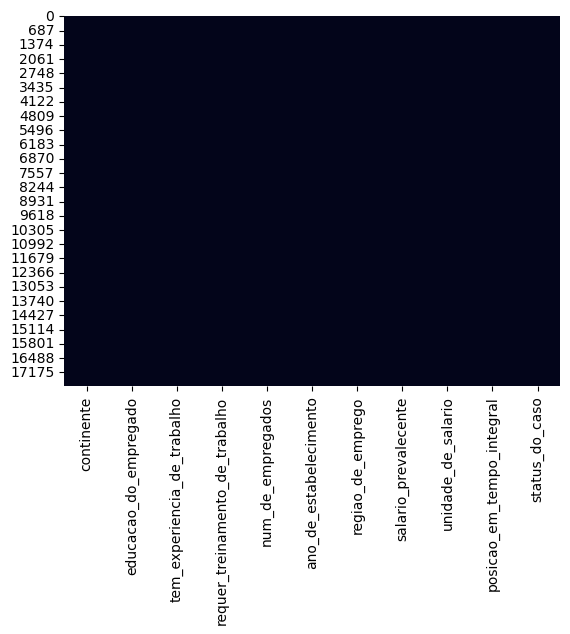

In [43]:
sns.heatmap(data_train.isnull(),cbar = False)
plt.show()

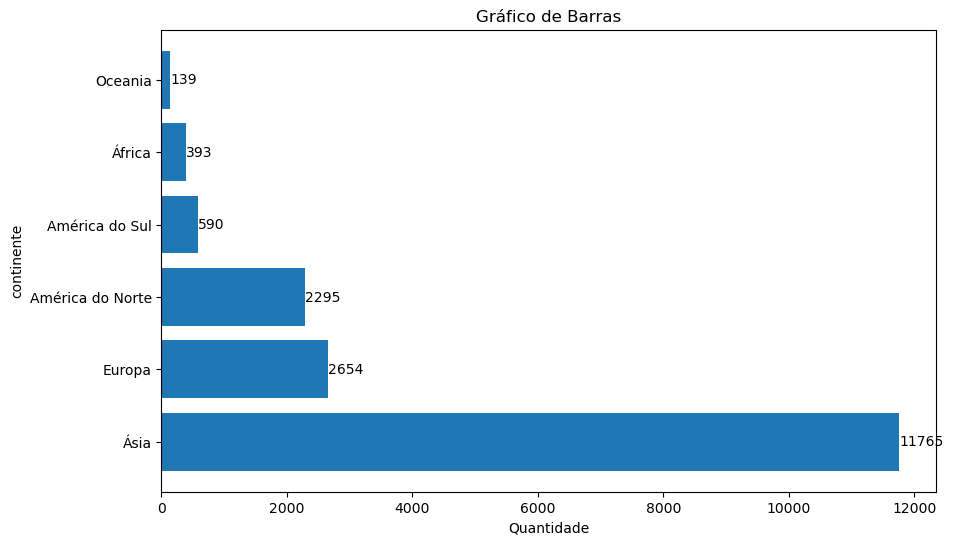

In [44]:
plotbar(data_train,'continente',horizontal=True)

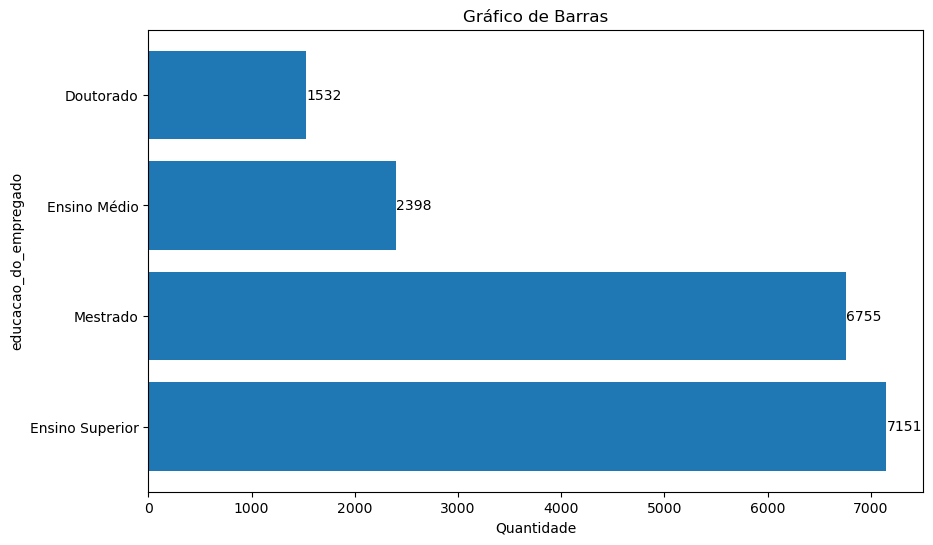

In [45]:
plotbar(data_train,'educacao_do_empregado',horizontal=True)

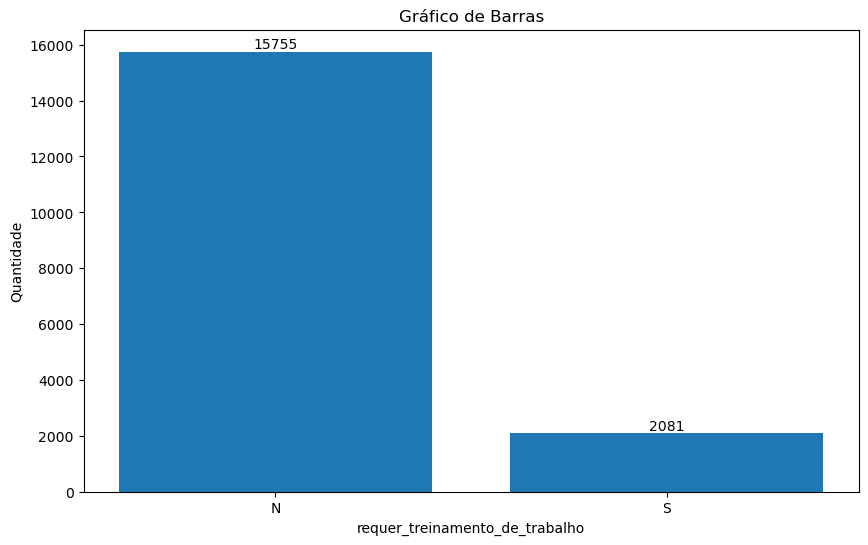

In [46]:
plotbar(data_train,'requer_treinamento_de_trabalho')

## Prepro

In [94]:
df = data_train

In [97]:
X = data_train.drop(columns='status_do_caso')
y = data_train['status_do_caso']

In [107]:
y[0]

'Negado'

In [120]:
# mapeando
y = y.apply(lambda x: 1 if x == "Aprovado" else 0 if x == "Negado" else None)


In [1]:
pipe_categorical = Pipeline([
    
    ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('enconder',OneHotEncoder(handle_unknown='ignore',sparse=False))
    
])
pipe_numerical = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer([
        ("num", pipe_numerical, numeric_features),
        ("cat", pipe_categorical, category_features),
]
)
preprocessor

NameError: name 'Pipeline' is not defined

In [124]:
clf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_de_empregados',
                                                   'ano_de_estabelecimento',
                                                   'salario_prevalecente']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('enconder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['continente',
                                                   'educacao_do_empregado',
                                                   'tem_experiencia_de_trabalho',
                                                   'requer_treinamento_de_trabalho',
                                                   'regiao_de_emprego',
                                                   'unidade_de_salario',
                                                   'posicao_em_tempo_integral'])])),
                ('model', LogisticRegression())])

In [130]:
# Aplicar o pipeline aos dados de treinamento
X_train_preprocessed = clf["preprocessor"].fit_transform(X_train)

# Treinar o modelo
clf.fit(X_train, y_train)

C:\Users\Reyso\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Reyso\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_de_empregados',
                                                   'ano_de_estabelecimento',
                                                   'salario_prevalecente']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('enconder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['continente',
                                                   'educacao_do_empregado',
                                                   'tem_experiencia_de_trabalho',
                                                   'requer_treinamento_de_trabalho',
                                                   'regiao_de_emprego',
                                                   'unidade_de_salario',
                                                   'posicao_em_tempo_integral'])])),
                ('model', LogisticRegression())])

In [133]:
# Fazer previsões nos dados de teste
y_pred = clf.predict(X_valid)

# Obter relatório de classificação
classification_report = classification_report(y_valid, y_pred)

print("Relatório de Classificação:")
print(classification_report)

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      2426
           1       0.63      0.46      0.53      1142

    accuracy                           0.74      3568
   macro avg       0.70      0.67      0.68      3568
weighted avg       0.73      0.74      0.73      3568



In [139]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_valid,
    pred_y[:,1],
)
micro_roc_auc_ovr

0.7664331822650996

In [140]:
data_test['status_do_caso'] = clf.predict(data_test)

In [141]:
submit_resp = data_test[['id_do_caso', 'status_do_caso']].replace({'status_do_caso': {'Aprovado':1, 'Negado':0}})

In [142]:
submit_resp

,id_do_caso,status_do_caso
0,EZYV22339,0
1,EZYV9333,0
2,EZYV9740,0
3,EZYV3328,0
4,EZYV12321,0
...,...,...
7639,EZYV19907,1
7640,EZYV576,0
7641,EZYV1804,0
7642,EZYV13543,0


In [143]:
submit_resp.to_csv('submission.csv', index=False)